In [26]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split   
from tensorflow.keras.callbacks import LearningRateScheduler


# a)

In [28]:
california_data = pickle.load(open('california-housing-dataset.pkl', 'rb')) # Load the data with pickle and readning it as a binary file
x_train, y_train = california_data['x_train'], california_data['y_train']
x_test, y_test = california_data['x_test'], california_data['y_test']


In [29]:
print("Training set dimensions:", x_train.shape, y_train.shape)


Training set dimensions: (15480, 8) (15480,)


In [30]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Sample x_train:", x_train[0])
print("Sample y_train:", y_train[0])


Shape of x_train: (15480, 8)
Shape of y_train: (15480,)
Sample x_train: [ 2.66180000e+00  1.00000000e+01  6.20408163e+00  1.25510204e+00
  1.40300000e+03  2.04518950e+00  3.41000000e+01 -1.16320000e+02]
Sample y_train: 0.81


In [31]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


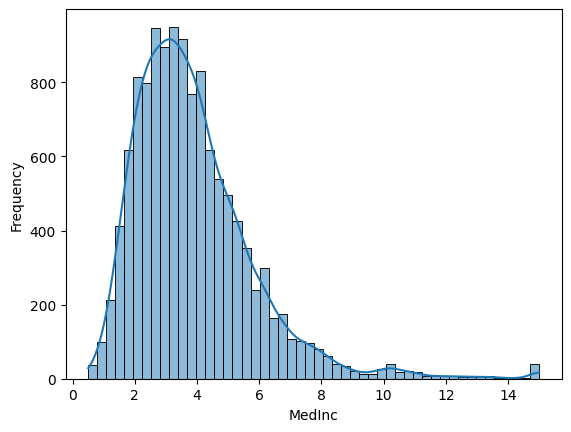

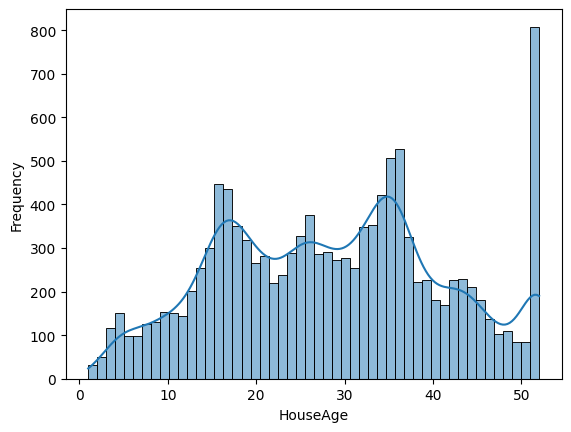

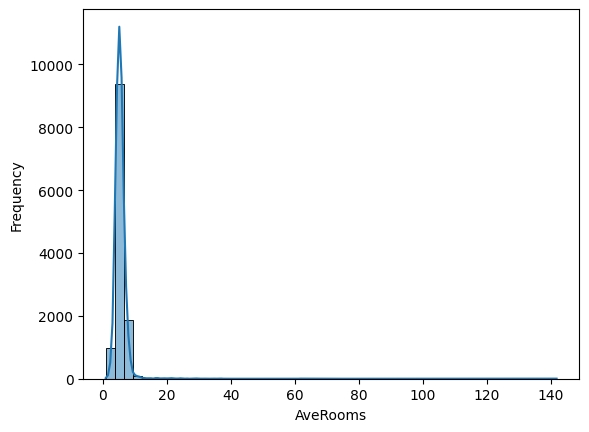

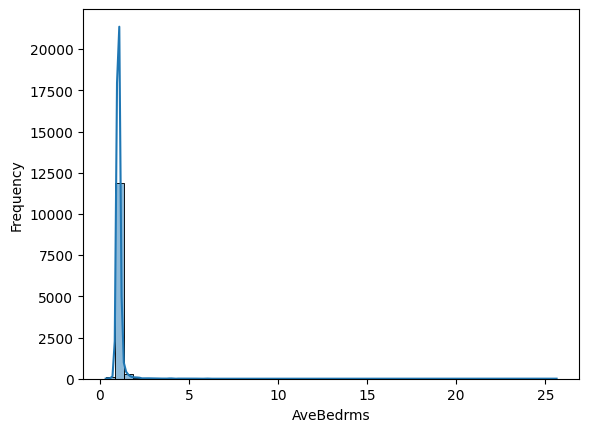

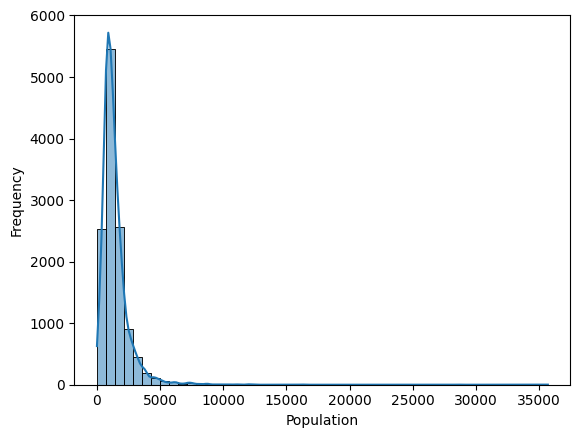

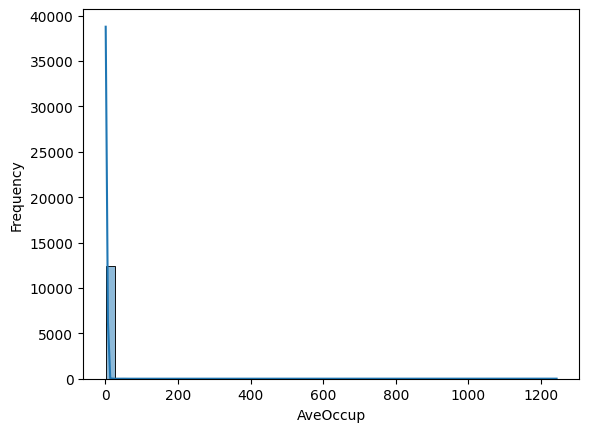

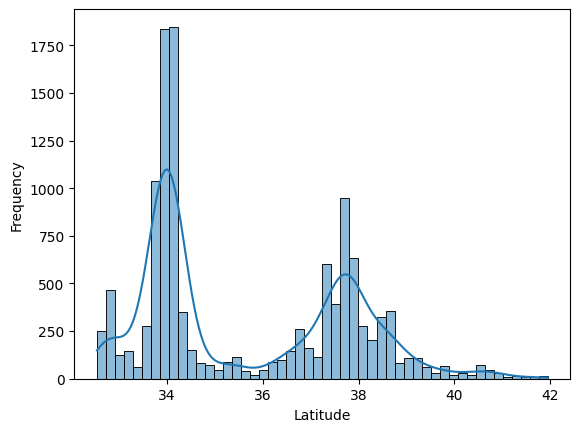

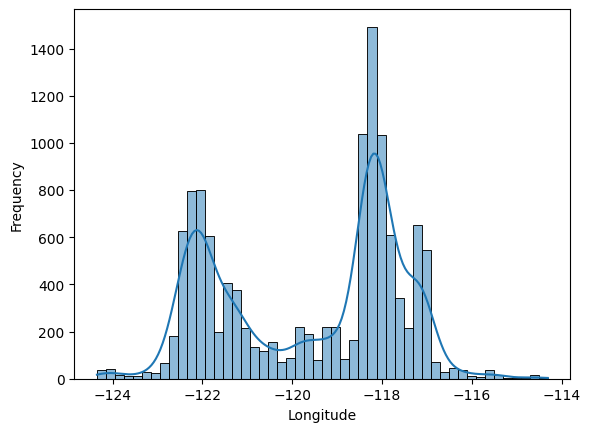

In [32]:
feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

for i in range(x_train.shape[1]):
    sns.histplot(x_train[:, i], bins=50, kde=True)
    plt.xlabel(feature_names[i])  # Use the feature name as x-axis label
    plt.ylabel('Frequency')
    plt.show()



In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_val_normalized = scaler.transform(x_val)
x_test_normalized = scaler.transform(x_test)


In [13]:
print("Sample normalized x_train:", x_train_normalized[0])
print("Sample normalized x_val:", x_val_normalized[0])
print("Sample normalized x_test:", x_test_normalized[0])

Sample normalized x_train: [0.2002662  0.1372549  0.03427405 0.02898204 0.0619727  0.00205002
 0.19659936 0.69820717]
Sample normalized x_val: [0.24946552 0.70588235 0.0312659  0.02854291 0.03570928 0.00194227
 0.16259299 0.6374502 ]
Sample normalized x_test: [0.11724666 0.52941176 0.02036826 0.02789164 0.04347339 0.00144336
 0.06057386 0.72410359]


# b)

In [9]:
def create_model(hidden_units=64, hidden_layers=2):
    model = keras.Sequential()

    model.add(keras.layers.InputLayer(input_shape=(x_train_normalized.shape[1],)))

    for _ in range(hidden_layers):
        model.add(keras.layers.Dense(units=hidden_units, activation='relu'))

    model.add(keras.layers.Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

architectures = [(32, 1), (64, 1), (64, 2), (128, 2)]  # We can add more architectures to test
results = []

for units, layers in architectures:
    model = create_model(hidden_units=units, hidden_layers=layers)

    history = model.fit(
        x_train_normalized, y_train,
        validation_data=(x_val_normalized, y_val),
        epochs=30, batch_size=32, verbose=0  # Adjust epochs and batch_size as needed
    )

    train_mse = mean_squared_error(y_train, model.predict(x_train_normalized))
    val_mse = mean_squared_error(y_val, model.predict(x_val_normalized))

    results.append({
        'Architecture': f'{layers} layers, {units} units',
        'Train MSE': train_mse,
        'Validation MSE': val_mse
    })

results_df = pd.DataFrame(results)



97/97 [==============================] - 0s 1ms/step


In [10]:
results_df.head()

,Architecture,Train MSE,Validation MSE
0,"1 layers, 32 units",0.513484,0.519450
1,"1 layers, 64 units",0.455158,0.465864
2,"2 layers, 64 units",0.478749,0.491555
3,"2 layers, 128 units",0.466545,0.479707


# c)

In [11]:

def create_model(optimizer='adam', learning_rate=0.001):
    model = keras.Sequential()

    model.add(keras.layers.InputLayer(input_shape=(x_train_normalized.shape[1],)))

    model.add(keras.layers.Dense(units=128, activation='relu'))
    model.add(keras.layers.Dense(units=64, activation='relu'))

    model.add(keras.layers.Dense(units=1))

    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='mean_squared_error')

    return model

def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

optimizers = [('SGD', keras.optimizers.SGD), ('MomentumSGD', keras.optimizers.SGD), ('Adam', keras.optimizers.Adam)]
learning_rates = [0.01, 0.001, 0.0001]
scheduled_results = []

for opt_name, optimizer in optimizers:
    for lr in learning_rates:
        model = create_model(optimizer=optimizer, learning_rate=lr)

        history = model.fit(
            x_train_normalized, y_train,
            validation_data=(x_val_normalized, y_val),
            epochs=20, batch_size=32, verbose=0,  # Adjust epochs and batch_size as needed
            callbacks=[LearningRateScheduler(lr_schedule)]  # Use learning rate schedule
        )

        train_mse = mean_squared_error(y_train, model.predict(x_train_normalized))
        val_mse = mean_squared_error(y_val, model.predict(x_val_normalized))

        scheduled_results.append({
            'Optimizer': opt_name,
            'Learning Rate': lr,
            'Train MSE': train_mse,
            'Validation MSE': val_mse
        })

scheduled_results_df = pd.DataFrame(scheduled_results)
results_df.head()


97/97 [==============================] - 0s 1ms/step


,Architecture,Train MSE,Validation MSE
0,"1 layers, 32 units",0.513484,0.519450
1,"1 layers, 64 units",0.455158,0.465864
2,"2 layers, 64 units",0.478749,0.491555
3,"2 layers, 128 units",0.466545,0.479707


In [12]:
results_df

,Architecture,Train MSE,Validation MSE
0,"1 layers, 32 units",0.513484,0.519450
1,"1 layers, 64 units",0.455158,0.465864
2,"2 layers, 64 units",0.478749,0.491555
3,"2 layers, 128 units",0.466545,0.479707


# d)

Epoch 1/30
387/387 [==============================] - 2s 3ms/step - loss: 0.9298 - val_loss: 0.5625
Epoch 2/30
387/387 [==============================] - 1s 2ms/step - loss: 0.5578 - val_loss: 0.5137
Epoch 3/30
387/387 [==============================] - 1s 3ms/step - loss: 0.5193 - val_loss: 0.4818
Epoch 4/30
387/387 [==============================] - 1s 2ms/step - loss: 0.4851 - val_loss: 0.4642
Epoch 5/30
387/387 [==============================] - 1s 2ms/step - loss: 0.4685 - val_loss: 0.4545
Epoch 6/30
387/387 [==============================] - 1s 2ms/step - loss: 0.4552 - val_loss: 0.4489
Epoch 7/30
387/387 [==============================] - 1s 2ms/step - loss: 0.4409 - val_loss: 0.4417
Epoch 8/30
387/387 [==============================] - 1s 2ms/step - loss: 0.4371 - val_loss: 0.4361
Epoch 9/30
387/387 [==============================] - 1s 2ms/step - loss: 0.4339 - val_loss: 0.4352
Epoch 10/30
387/387 [==============================] - 1s 2ms/step - loss: 0.4327 - val_loss: 0.4297

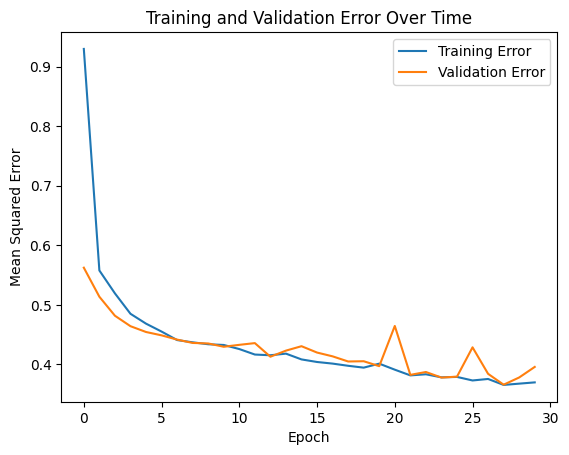

162/162 [==============================] - 0s 1ms/step - loss: 0.3771
Final Test MSE: 0.37709522247314453
162/162 [==============================] - 0s 1ms/step


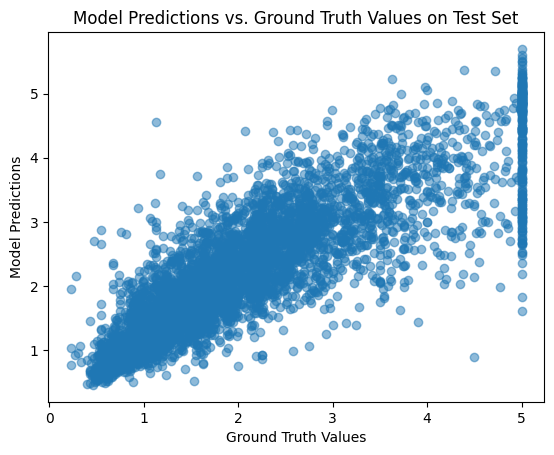

In [13]:
final_model = create_model(optimizer=keras.optimizers.Adam, learning_rate=0.001)

final_history = final_model.fit(
    x_train_normalized, y_train,
    validation_data=(x_val_normalized, y_val),
    epochs=30, batch_size=32, verbose=1  # Adjust epochs and batch_size as needed
)

plt.plot(final_history.history['loss'], label='Training Error')
plt.plot(final_history.history['val_loss'], label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Error Over Time')
plt.legend()
plt.show()

test_mse = final_model.evaluate(x_test_normalized, y_test)

print("Final Test MSE:", test_mse)

predictions = final_model.predict(x_test_normalized)

plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Ground Truth Values')
plt.ylabel('Model Predictions')
plt.title('Model Predictions vs. Ground Truth Values on Test Set')
plt.show()


# e)

In [ ]:
import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Redefine the target variables for binary classification
y_train[y_train < 2] = 0
y_train[y_train >= 2] = 1
y_test[y_test < 2] = 0
y_test[y_test >= 2] = 1

# Define and create your binary classification model
binary_model = create_binary_classification_model(optimizer=keras.optimizers.Adam, learning_rate=0.001)

# Train the binary classification model on the entire training set
binary_history = binary_model.fit(
    x_train_normalized, y_train,
    validation_data=(x_val_normalized, y_val),
    epochs=30, batch_size=32, verbose=1  # Adjust epochs and batch_size as needed
)

# Evaluate the binary classification model on the test set
binary_predictions = binary_model.predict(x_test_normalized)
binary_predictions = (binary_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Report and comment on the performance of the binary classification model
print("Binary Classification Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


=============================================================================================================

In [18]:
df_train = pd.DataFrame(x_train, columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])
df_train['MedianHouseValue'] = y_train * 100000  # Convert target variable back to dollars

df_train.describe().round(2)    


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
count,15480.00,15480.00,15480.00,15480.00,15480.00,15480.00,15480.00,15480.00,15480.00
mean,3.88,28.66,5.44,1.10,1421.97,3.08,35.64,-119.58,206898.99
std,1.91,12.60,2.61,0.51,1149.21,10.98,2.14,2.01,115706.92
min,0.50,1.00,0.85,0.33,5.00,0.69,32.54,-124.35,14999.00
25%,2.57,18.00,4.43,1.01,786.00,2.43,33.93,-121.80,119400.00
50%,3.54,29.00,5.23,1.05,1161.00,2.82,34.26,-118.50,179400.00
75%,4.74,37.00,6.05,1.10,1715.00,3.28,37.72,-118.01,265325.00
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,500001.00


In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)

x_test_scaled = scaler.transform(x_test)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(64, input_dim=8, activation='relu'))
model.add(Dense(1, activation='linear'))

custom_optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=custom_optimizer, loss='mean_squared_error')

model.fit(x_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
387/387 [==============================] - 1s 2ms/step - loss: 1.4377 - val_loss: 0.7474
Epoch 2/50
387/387 [==============================] - 1s 2ms/step - loss: 0.6580 - val_loss: 0.5716
Epoch 3/50
387/387 [==============================] - 1s 2ms/step - loss: 0.5975 - val_loss: 0.5514
Epoch 4/50
387/387 [==============================] - 1s 2ms/step - loss: 0.5827 - val_loss: 0.5377
Epoch 5/50
387/387 [==============================] - 1s 2ms/step - loss: 0.5698 - val_loss: 0.5270
Epoch 6/50
387/387 [==============================] - 1s 2ms/step - loss: 0.5594 - val_loss: 0.5169
Epoch 7/50
387/387 [==============================] - 1s 2ms/step - loss: 0.5491 - val_loss: 0.5110
Epoch 8/50
387/387 [==============================] - 1s 2ms/step - loss: 0.5422 - val_loss: 0.5029
Epoch 9/50
387/387 [==============================] - 1s 2ms/step - loss: 0.5351 - val_loss: 0.4947
Epoch 10/50
387/387 [==============================] - 1s 2ms/step - loss: 0.5288 - val_loss: 0.4922

In [21]:
test_loss = model.evaluate(x_test_scaled, y_test)
print(f"Test Loss: {test_loss}")


162/162 [==============================] - 0s 2ms/step - loss: 0.4208
Test Loss: 0.4208061695098877


In [15]:
import matplotlib.pyplot as plt

history = model.history.history

# Plot training loss and validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


KeyError: 'test_loss'